# Profiling and Optimising

IPython provides some tools for making it a bit easier to profile and optimise your code.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

## `%timeit`

The main IPython tool we are going to use here is `%timeit`,
a magic that automates measuring how long it takes to run a snippet of code.

In [3]:
for N in (100, 500, 1000, 2000):
    print("Size: {0} x {0}".format(N))
    A = np.random.random((N, N))
    %timeit A.dot(A)

Size: 100 x 100
10000 loops, best of 3: 125 µs per loop
Size: 500 x 500
100 loops, best of 3: 9.15 ms per loop
Size: 1000 x 1000
10 loops, best of 3: 73.6 ms per loop
Size: 2000 x 2000
1 loops, best of 3: 494 ms per loop


Let's look at what options `%timeit` can take.

In [4]:
%timeit?

Docstring:
Time execution of a Python statement or expression

Usage, in line mode:
  %timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] statement
or in cell mode:
  %%timeit [-n<N> -r<R> [-t|-c] -q -p<P> -o] setup_code
  code
  code...

Time execution of a Python statement or expression using the timeit
module.  This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, the statement in the first line is used as setup code
  (executed but not timed) and the body of the cell is timed.  The cell
  body has access to any variables created in the setup code.

Options:
-n<N>: execute the given statement <N> times in a loop. If this value
is not given, a fitting value is chosen.

-r<R>: repeat the loop iteration <R> times and take the best result.
Default: 3

-t: use time.time to measure the time, which is the default on Unix.
This function measures wall time.

-c: use t

We can save the result in an object with `%timeit -o`,
and specify to only run one group of 100 iterations.

In [5]:
A = np.random.random((100, 100))
tr = %timeit -o -n 1 -r 100 A.dot(A)

1 loops, best of 100: 119 µs per loop


In [ ]:
tr.

In [6]:
tr.best, tr.worst

(0.00011933001223951578, 0.0002903500135289505)

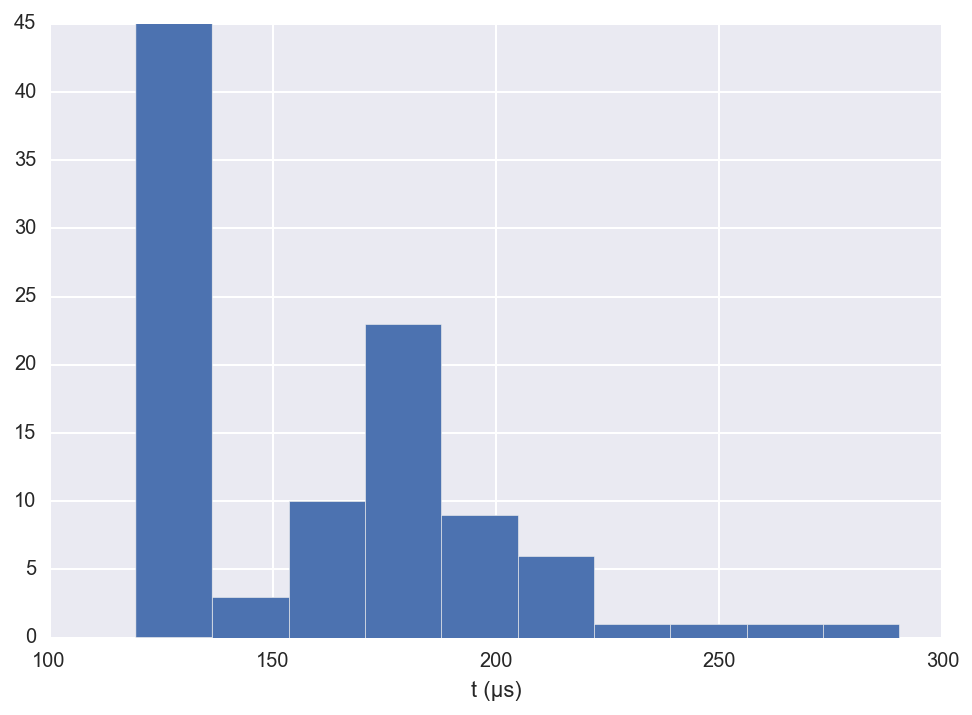

In [7]:
plt.hist(np.array(tr.all_runs) * 1e6)
plt.xlabel("t (µs)")

## Diffusing a wave

Our task is to optimise a 1-D diffusion algorithm,
using numpy and Cython.

Our input signal is a sawtooth wave:

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (2\pi kft)}{k}
$$

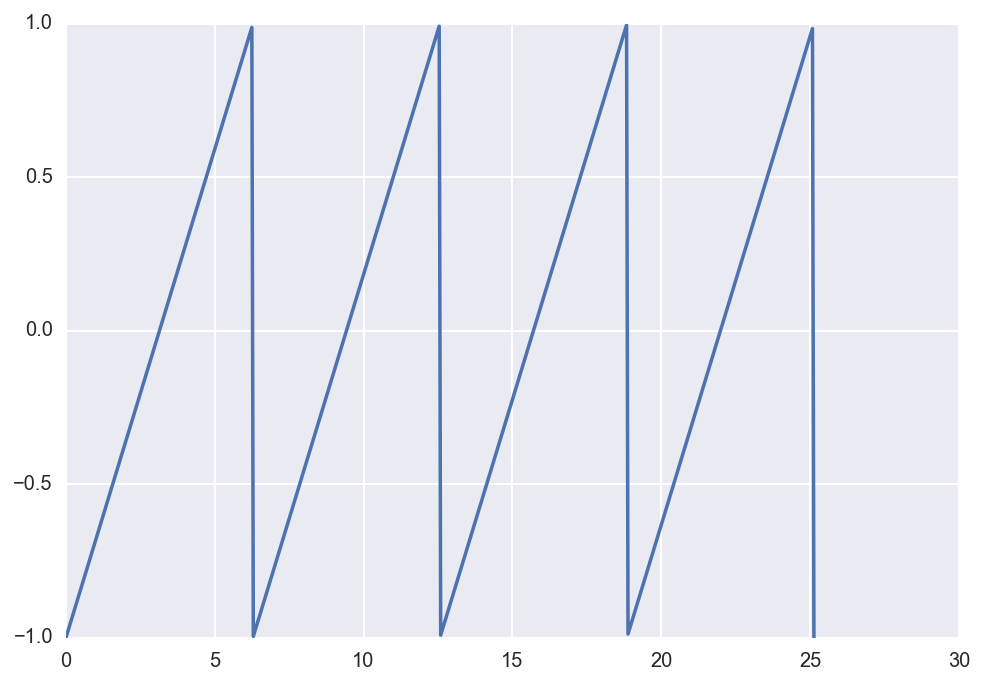

In [8]:
from scipy.signal import sawtooth

T = 8 * np.pi
t = np.linspace(0, T, 512)
x = sawtooth(t)
plt.plot(t, x)

steps = 2048

We are going to diffuse the wave by evolving the heat equation:

$$
\frac{\delta x}{\delta t} = \alpha \frac{\delta^2 x}{\delta^2}{t}
$$

Which we can discretize for our arrays:

\begin{align}
x_{k} =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) \\
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
\end{align}

## Pure Python

We'll start with a pure Python implementation,
to use as a reference.

In [9]:
def blur_py(x, steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

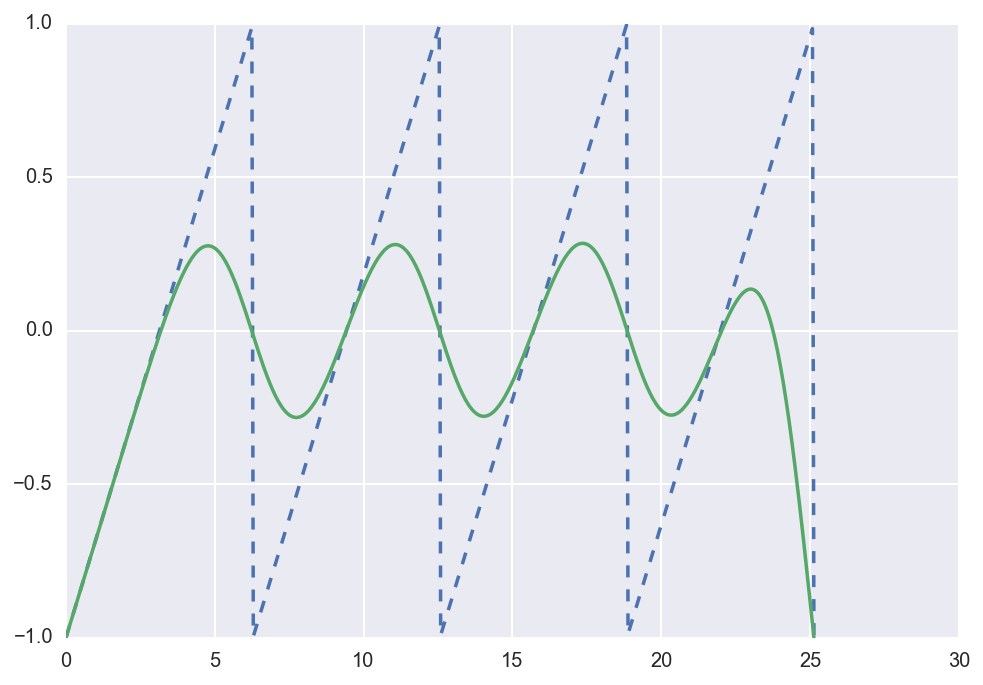

In [10]:
y = blur_py(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

Now we can measure how long it takes to run evolve this system:

In [11]:
ref_run = %timeit -o y = blur_py(x, steps)
t_ref = ref_run.best

times = [t_ref]
labels = ['python']

1 loops, best of 3: 1.17 s per loop


So it takes about one second.
We can also see how it changes with different times and resolutions.

## Vectorizing with numpy

We can vectorize the inner loop with a single numpy operation:

In [12]:
import numpy as np

def blur_np(x, steps=1024):
    x = 1 * x
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        y[1:-1] = .25 * (x[:-2] + 2 * x[1:-1] + x[2:])
        x, y = y, x
    return x

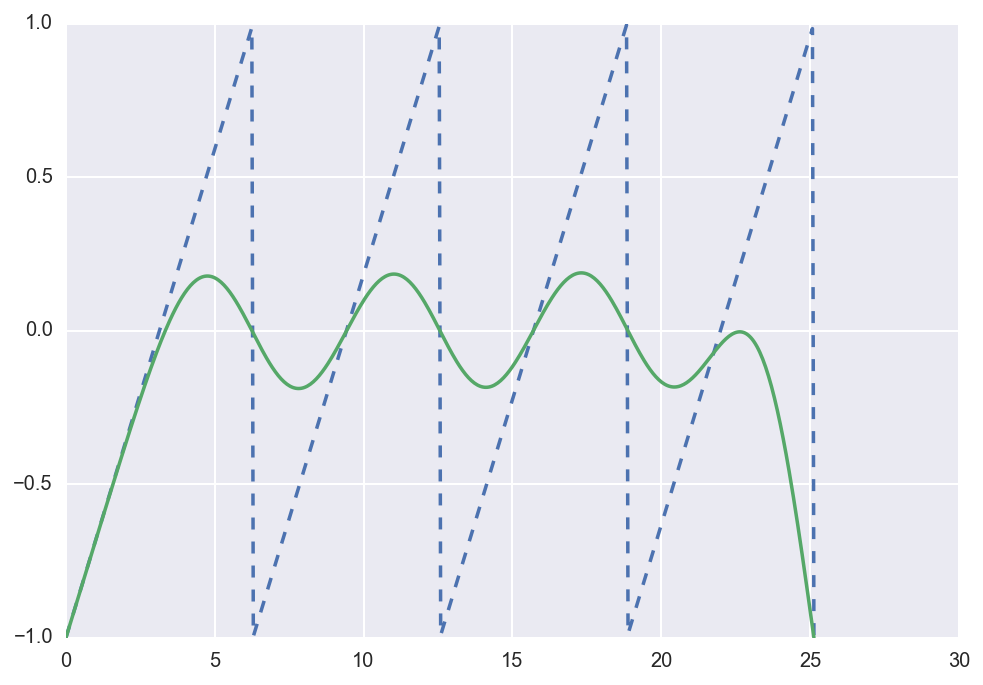

In [13]:
y = blur_np(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

In [14]:
np_r = %timeit -o blur_np(x, steps)
t_np = np_r.best

10 loops, best of 3: 25.8 ms per loop


In [15]:
times.append(t_np)
labels.append('numpy')

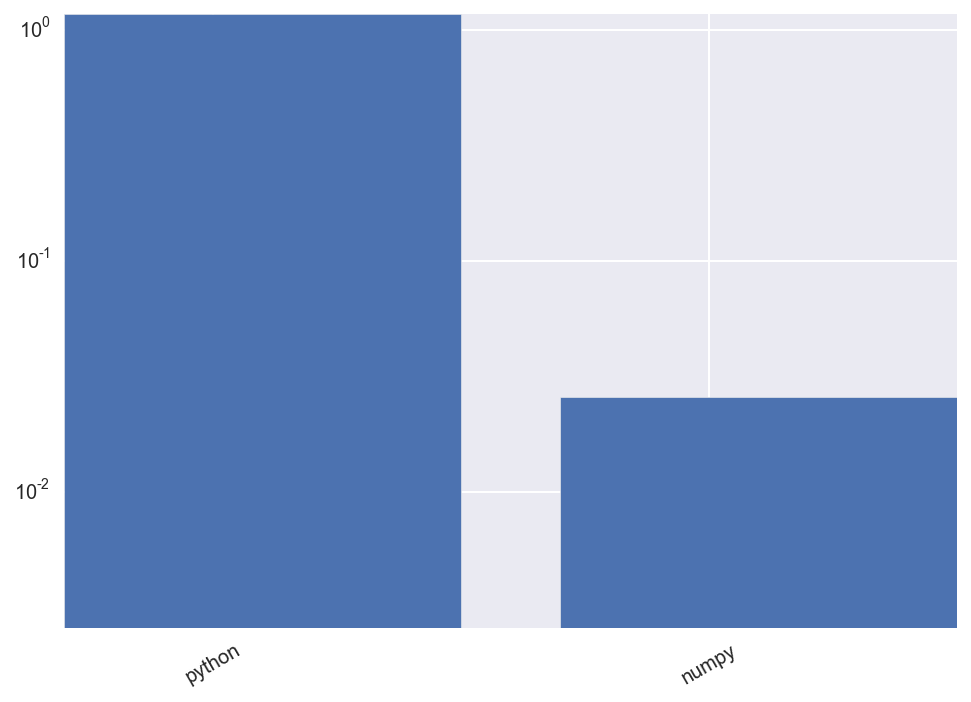

In [16]:
def plot_times():
    ind = np.arange(len(times))
    plt.bar(ind, times, log=True)
    plt.xticks(ind + 0.3, labels, rotation=30)
    plt.ylim(.1 * min(times), times[0])
plot_times()

So vectorizing the inner loop brings us from 1 second to 25 milliseconds,
an improvement of 40x:

In [17]:
t_ref / t_np

45.41602984680184

# Cython

[Cython](http://cython.org/) provides an IPython extension,
which defines a magic we can use to inline bits of Cython code in the notebook:

In [18]:
%load_ext Cython

In [19]:
%%cython

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [20]:
%timeit csum(5)

The slowest run took 5.15 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 595 ns per loop


`%%cython -a` shows you annotations about the generated sourcecode.
The key to writing Cython is to minimize the amount of Python calls in the generated code. In general: yellow = slow.

In [21]:
def psum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [22]:
%%cython -a

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

Uh oh, that looks like a lot of yellow.
We can reduce it by adding some type annotations:

In [23]:
%%cython -a

def csum2(int n):
    cdef int i
    cs = 0
    for i in range(n):
        cs += i
    return cs

Almost there, but I still see yellow on the lines with `cs`:

In [24]:
%%cython -a

def csum3(int n):
    cdef int i
    cdef int cs = 0
    for i in range(n):
        cs += i
    return cs

Much better!
Now there's only Python when entering and leaving the function,
which is about as good as we can do.

In [25]:
N = 100000
%timeit psum (N)
%timeit csum (N)
%timeit csum2(N)
%timeit csum3(N)

100 loops, best of 3: 10.1 ms per loop
100 loops, best of 3: 5.4 ms per loop
100 loops, best of 3: 5.49 ms per loop
The slowest run took 12.78 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 123 ns per loop


## Blurring with Cython

Now we can apply the same principles to writing a blur
in Cython.

In [26]:
%%cython -a

import numpy as np

def blur_cython(x, steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, y = y, x # swap for next step
    return x

In [27]:
c1 = %timeit -o y = blur_cython(x, steps)
t_c1 = c1.best
times.append(t_c1)
labels.append("cython (no hints)")

1 loops, best of 3: 869 ms per loop


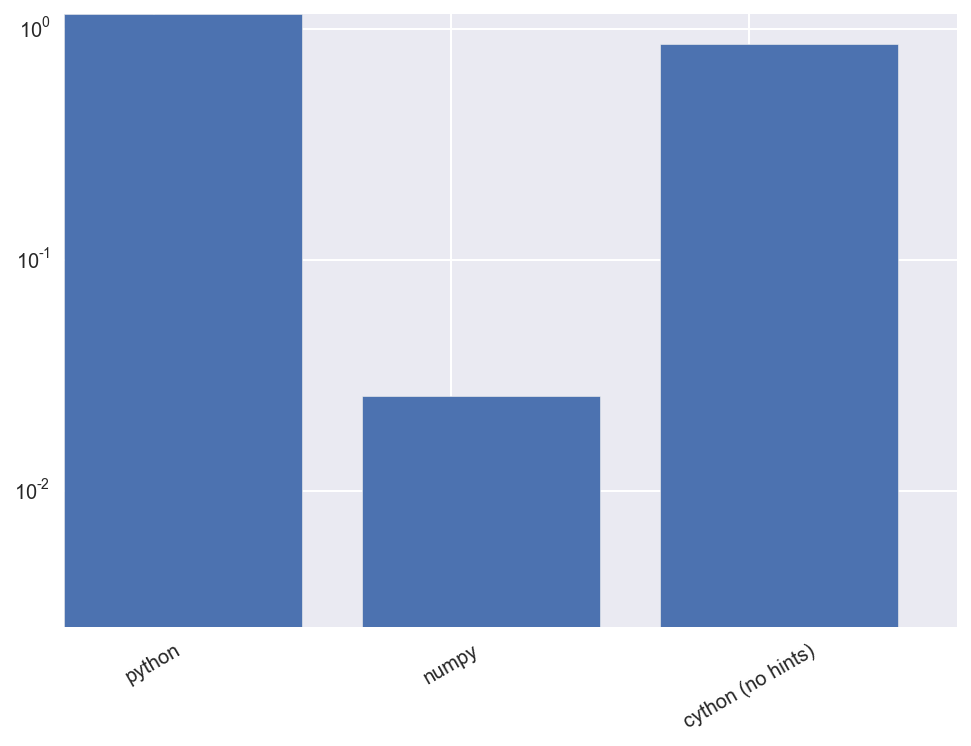

In [28]:
plot_times()

Without annotations, we don't get much improvement over the pure Python version.
We can note the types of the input arguments, to get some improvements:

In [29]:
%%cython -a

import numpy as np
cimport numpy as np

def blur_cython2(x, int steps=1024):
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    cdef int i, N = len(x)
    for _ in range(steps):
        for i in range(1, N-1):
            y[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, y = y, x # swap for next step
    return x

1 loops, best of 3: 663 ms per loop


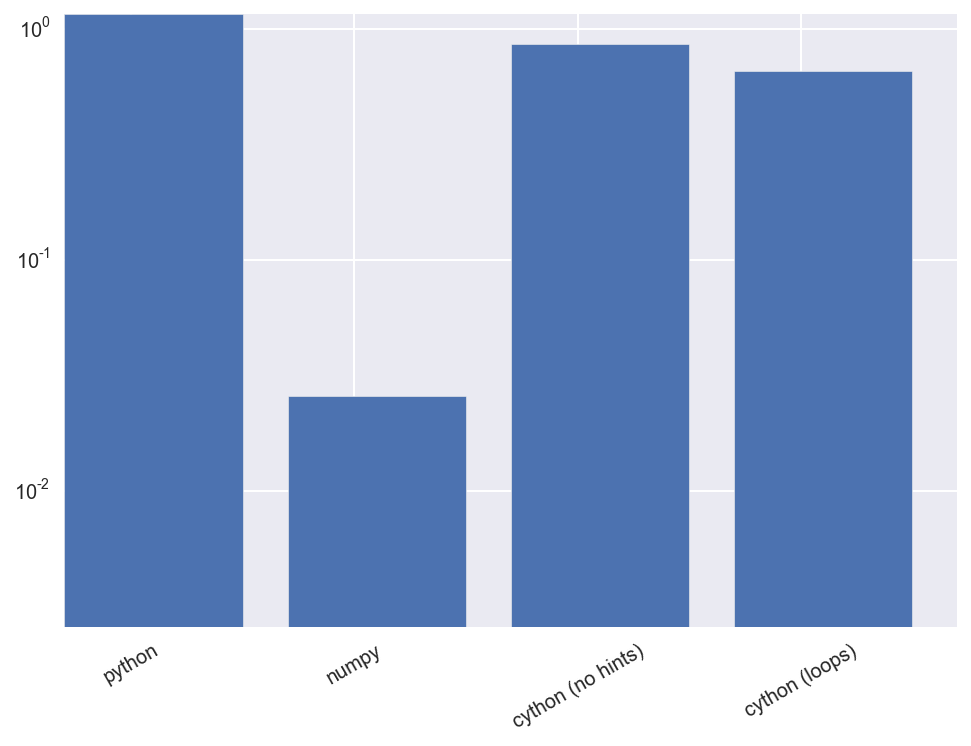

In [30]:
c2 = %timeit -o blur_cython2(x, steps)
t_c2 = c2.best
times.append(t_c2)
labels.append("cython (loops)")
plot_times()

Just by making sure the iteration variables are defined as integers, we can save about 25% of the time.

The biggest key to optimizing with Cython is getting that yellow out of your loops.
The more deeply nested a bit of code is within a loop,
the more often it is called, and the more value you can get out of making it fast.
In Cython, fast means avoiding Python (getting rid of yellow).
To get rid of Python calls, we need to tell Python about the numpy arrays `x` and `y`:


In [31]:
%%cython -a

import numpy as np
cimport numpy as np

def blur_cython_typed(np.ndarray[double, ndim=1] x_, int steps=1024):
#     x = 1 * x # copy
    cdef size_t i, N = x_.shape[0]
    cdef np.ndarray[double, ndim=1] x
    cdef np.ndarray[double, ndim=1] y
    x = 1 * x_
    y = np.empty_like(x_)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, N-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

100 loops, best of 3: 8.44 ms per loop


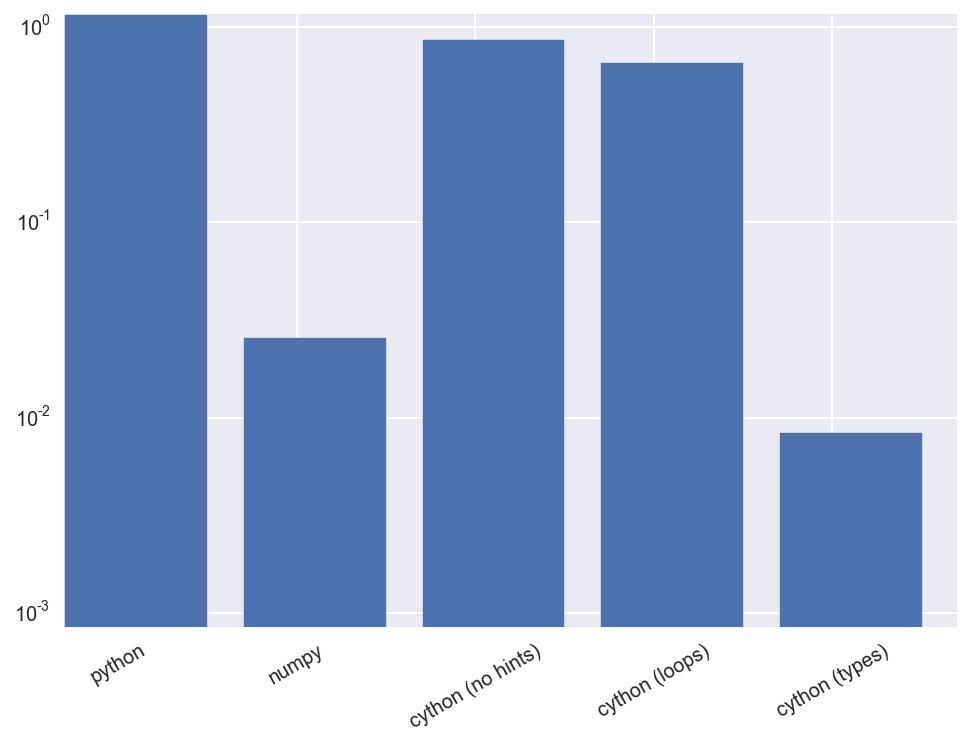

In [32]:
ct = %timeit -o y = blur_cython_typed(x, steps)
t_ct = ct.best

times.append(t_ct)
labels.append("cython (types)")
plot_times()

We can furter optimize with Cython macros,
which disable bounds checking and negative indexing,
and avoiding the Python variable swaping by using indices into a single array:

In [33]:
%%cython -a
#cython: boundscheck=False
#cython: wraparound=False

import numpy as np
cimport numpy as np

def blur_cython_optimized(np.ndarray[double, ndim=1] x, int steps=1024):
    cdef size_t N = x.shape[0]
    cdef np.ndarray[double, ndim=2] y
    y = np.empty((2, N), dtype=np.float64)
    y[0,:] = x
    y[1,0] = x[0]
    y[1,N-1] = x[N-1]
    
    cdef size_t _, i, j=0, k=1
    for _ in range(steps):
        j = _ % 2
        k = 1 - j
        for i in range(1, N-1):
            y[k,i] = .25 * ( y[j,i-1] + 2 * y[j,i] + y[j,i+1] )
    return y[k]

Note how there is now zero yellow called in any of the loops,
only in the initial copy of the input array.

1000 loops, best of 3: 1.83 ms per loop


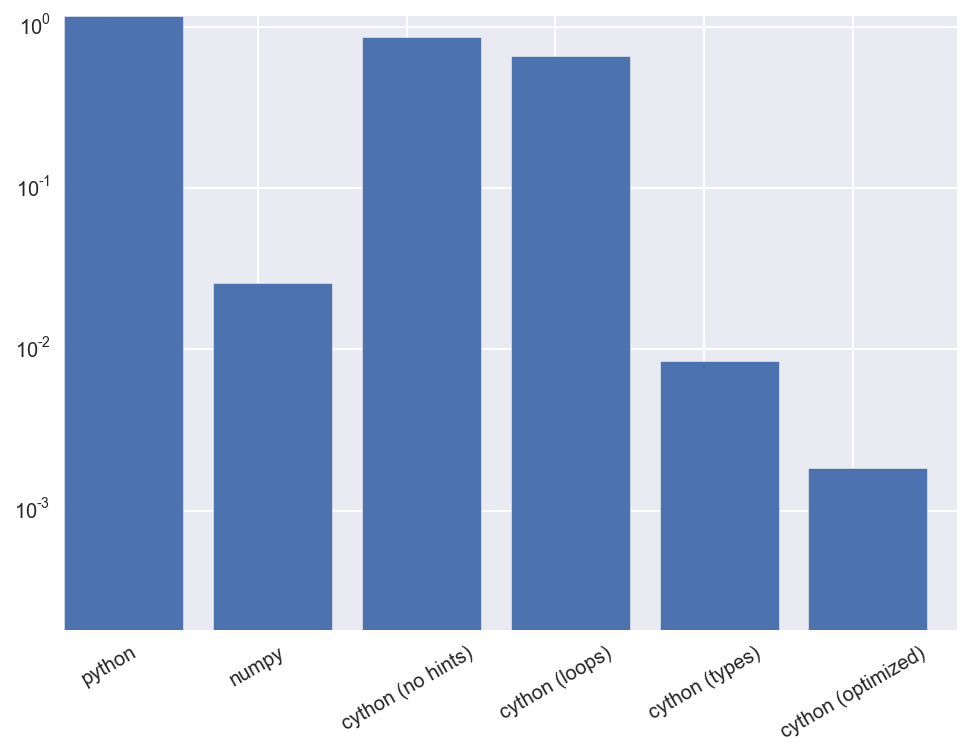

In [34]:
copt = %timeit -o y = blur_cython_optimized(x, steps)
t_copt = copt.best
times.append(t_copt)
labels.append("cython (optimized)")
plot_times()

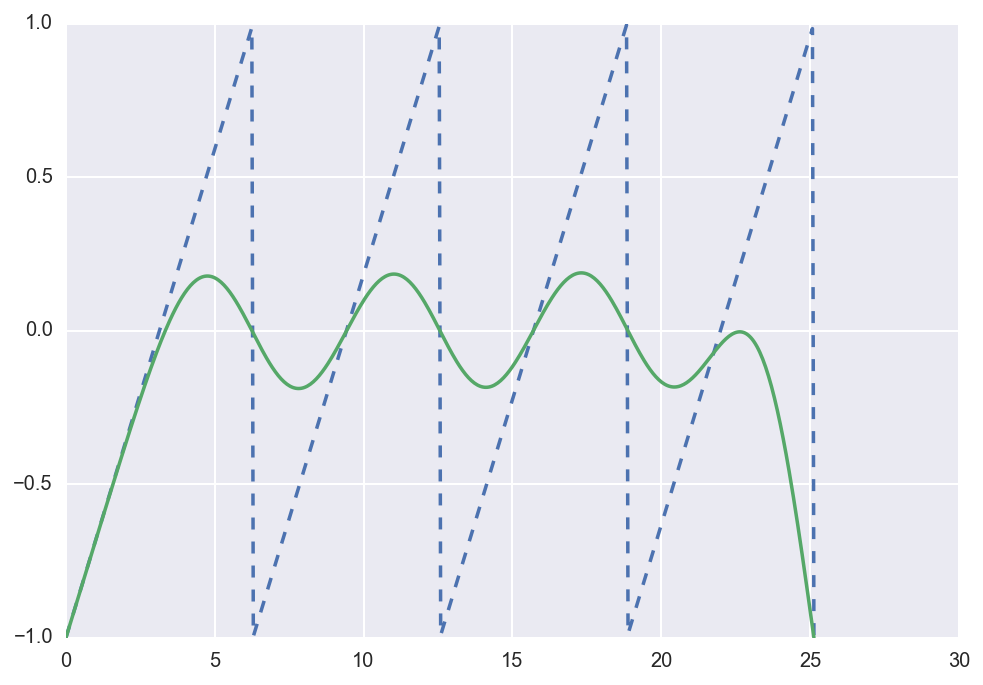

In [36]:
y = blur_cython_optimized(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

## numba

[numba](http://numba.pydata.org/) is a library that attempts to automatically do type-based optimizations like we did with Cython.
To use numba, you decorate functions with `@autojit`.

In [37]:
import numba

@numba.autojit
def blur_numba(x, steps=1024):
    """identical to blur_py, other than the decorator"""
    x = 1 * x # copy
    y = np.empty_like(x)
    y[0] = x[0]
    y[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x)-1):
            y[i] = .25 * ( y[i-1] + 2 * y[i] + y[i+1] )
        x, y = y, x # swap for next step
    return x

y = blur_numba(x, steps)

100 loops, best of 3: 4.2 ms per loop


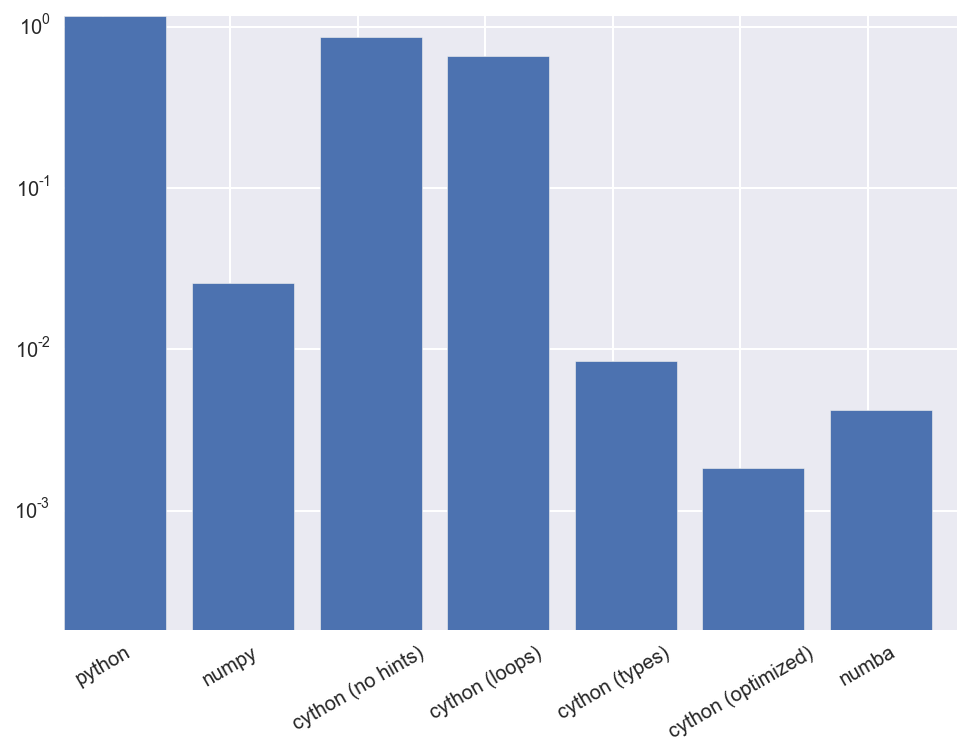

In [38]:
nb = %timeit -o blur_numba(x, steps)
t_nb = nb.best
times.append(t_nb)
labels.append("numba")
plot_times()

What's impressive about numba in this case
is that it is able to beat all but the most optimized of our implementations without any help.
Like Cython, numba can do an even better job when you provide it with more information about how a function will be called.